# SPACEc: ML-enabled cell type annotation

After preprocessing the single-cell data, the next step is to assign cell types. SPACEc utilizes the linear SVM model to train and classify to annotate cell types if training data is available.

## Set up environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# silencing warnings
import warnings
warnings.filterwarnings('ignore')

#import standard packages
import os
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns

In [3]:
import spacec as sp

2024-01-16 08:39:57.178644: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mgbckr/miniconda3/envs/yuqi-spacodex/lib/python3.10/site-packages/cv2/../../lib64:
2024-01-16 08:39:57.178671: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
root_path = pathlib.Path("..")

data_path = root_path / 'data' # where the data is stored

# where you want to store the output
output_dir = root_path / '_out'
output_dir.mkdir(exist_ok=True, parents=True)

In [5]:
sc.settings.set_figure_params(dpi=80, facecolor='white')

## Data Explanation
Annotated tonsil data is used as training & test data. </br>
Tonsillitis data is used as validation data.

In [6]:
# Load training data
adata = sc.read(output_dir / "adata_nn_demo_annotated.h5ad")
adata_train = adata[adata.obs['condition'] == 'tonsil']
adata_val  = adata[adata.obs['condition'] == 'tonsillitis']

## 3.1 Training

In [11]:
import numpy as np
np.isnan(adata_train.X).sum()

0

['B', 'CD4T', 'CD8T', 'DC', 'GCB', ..., 'Plasma', 'Treg', 'Vessel', 'cDC1', 'epithelia']
Length: 13
Categories (13, object): ['B', 'CD4T', 'CD8T', 'DC', ..., 'Treg', 'Vessel', 'cDC1', 'epithelia']
Training now!
Evaluating now!


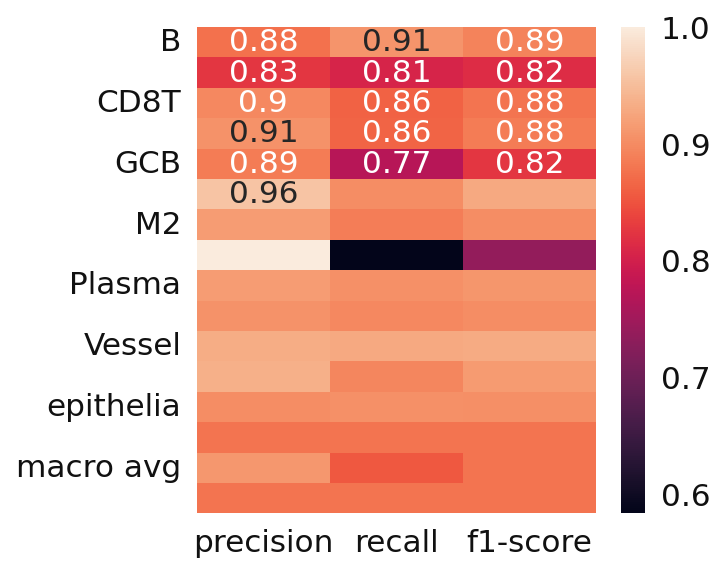

In [29]:
svc = sp.tl.ml_train(
    adata_train=adata_train,
    label='celltype',
    nan_policy_y='omit')

In [30]:
sp.tl.ml_predict(
    adata_val = adata_val,
    svc = svc,
    save_name = "svm_pred")

Classifying!
Saving cell type labels to adata!


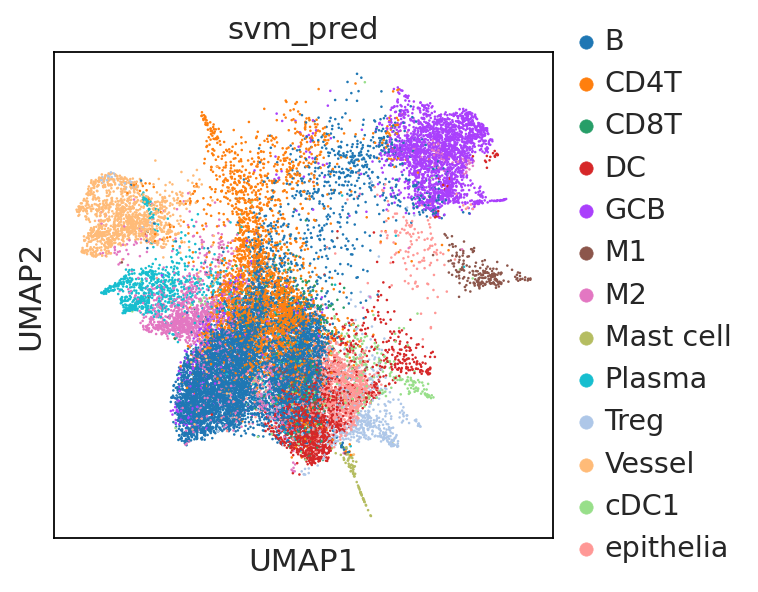

In [31]:
sc.pl.umap(adata_val, color = 'svm_pred')

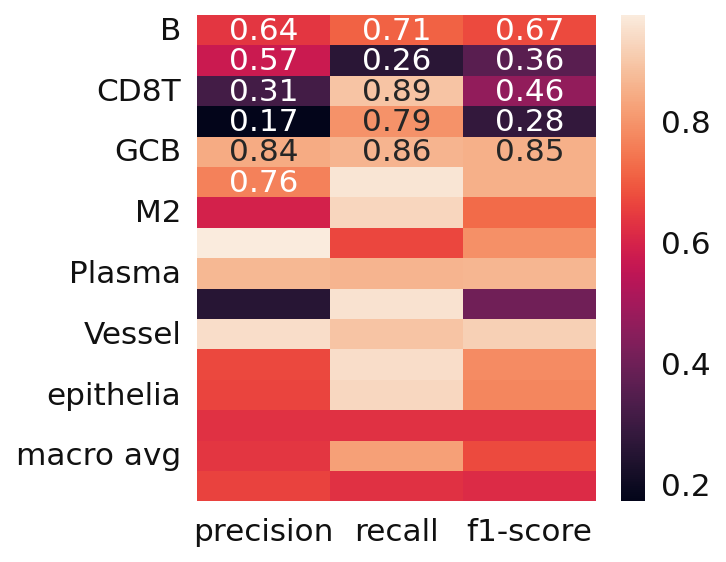

In [33]:
# Since we also know the cell type annotation of the adata_val, we can check in this case
from sklearn.metrics import classification_report

y_true = adata_val.obs['celltype'].values
y_pred = adata_val.obs['svm_pred'].values
nan_mask = ~y_true.isna()
y_true = y_true[nan_mask]
y_pred = y_pred[nan_mask]

svm_eval = classification_report(
    y_true = y_true, 
    y_pred = y_pred, 
    target_names=svc.classes_, 
    output_dict=True)
sns.heatmap(
    pd.DataFrame(svm_eval).iloc[:-1, :].T, 
    annot=True)
plt.show()

### 3.4 Save model

In [35]:
import pickle
filename = 'svc_model.sav'
pickle.dump(svc, open(output_dir / filename, 'wb'))
#adata_val.write(output_dir + "adata_nn_ml_demo_annotated.h5ad")

## 3.5 Single-cell visualzation

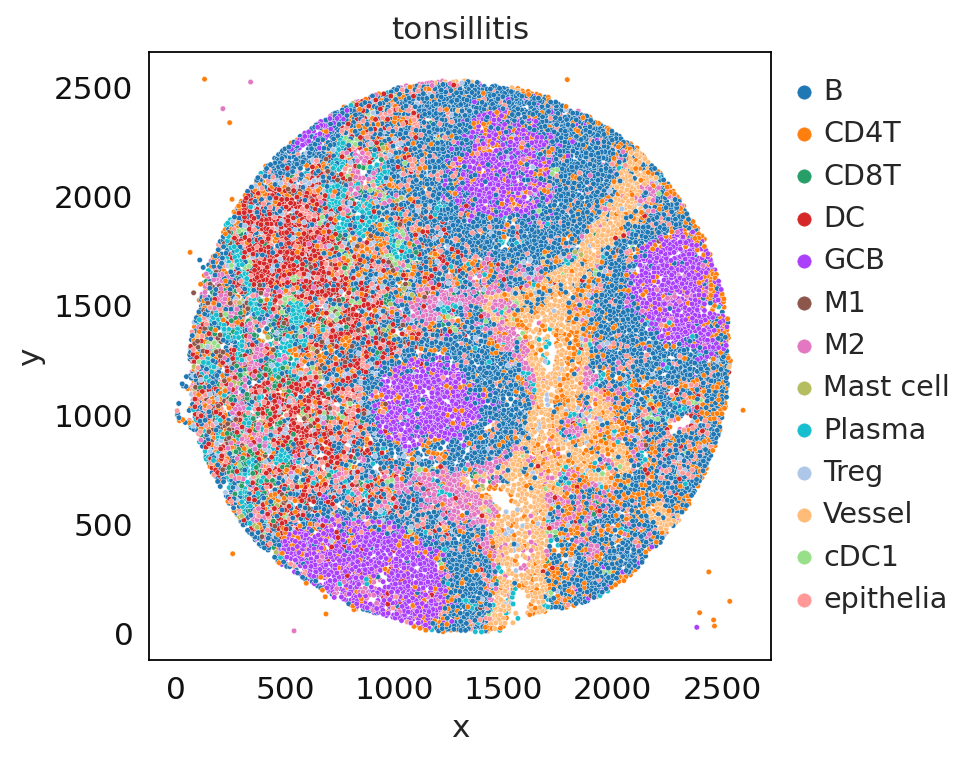

In [36]:
sp.pl.catplot(
    adata_val, color = "svm_pred", # specify group column name here e.g. celltype_fine)
    unique_region = "condition", # specify unique_regions here
    X='x', Y='y', # specify x and y columns here
    n_columns=1, # adjust the number of columns for plotting here (how many plots do you want in one row?)
    palette=None, #default is None which means the color comes from the anndata.uns that matches the UMAP
    savefig=False, # save figure as pdf
    output_fname = "", # change it to file name you prefer when saving the figure
    output_dir=output_dir, # specify output directory here (if savefig=True)
)

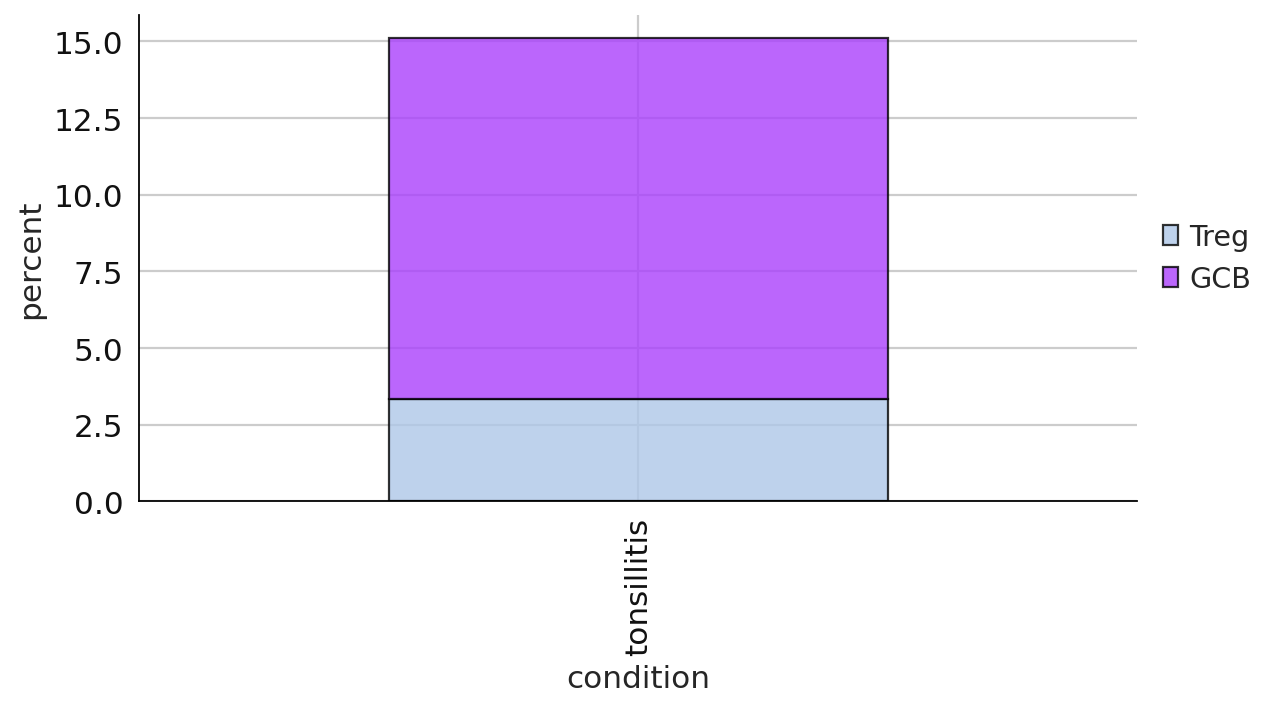

In [37]:
# cell type percentage tab and visualization [much few]
ct_perc_tab, _ = sp.pl.stacked_bar_plot(
    adata = adata_val, # adata object to use 
    color = 'svm_pred', # column containing the categories that are used to fill the bar plot
    grouping = 'condition', # column containing a grouping variable (usually a condition or cell group) 
    cell_list = ['GCB', 'Treg'],  # list of cell types to plot, you can also see the entire cell types adata.obs['celltype_fine'].unique()
    palette=None, #default is None which means the color comes from the anndata.uns that matches the UMAP
    savefig=False, # change it to true if you want to save the figure
    output_fname = "", # change it to file name you prefer when saving the figure
    output_dir = output_dir, #output directory for the figure
    norm = False # if True, then whatever plotted will be scaled to sum of 1
)

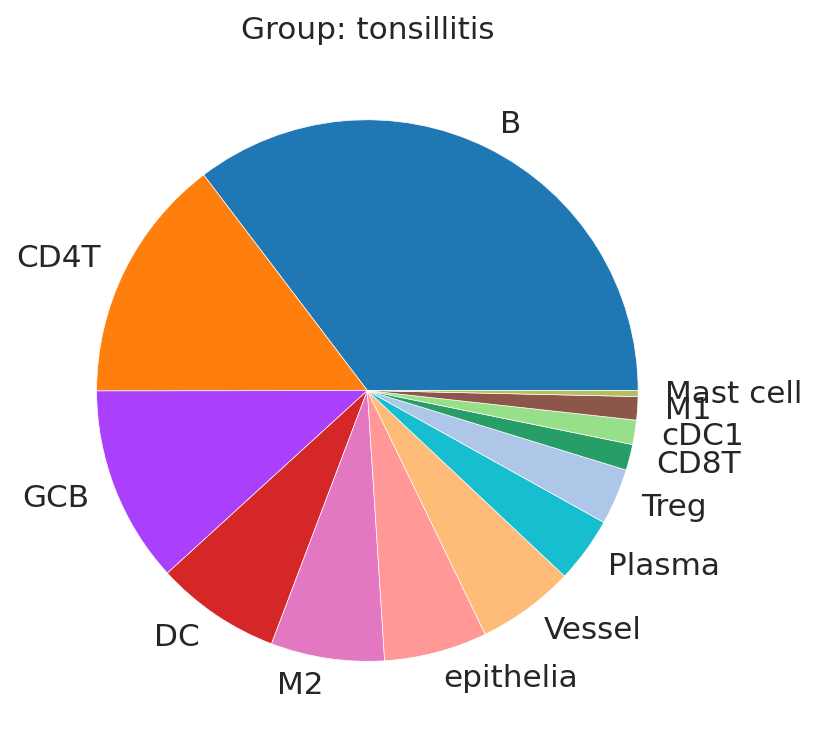

In [39]:
sp.pl.create_pie_charts(
    adata_val,
    color = "svm_pred", 
    grouping = "condition", 
    show_percentages=False,
    palette=None, #default is None which means the color comes from the anndata.uns that matches the UMAP
    savefig=False, # change it to true if you want to save the figure
    output_fname = "", # change it to file name you prefer when saving the figure
    output_dir = output_dir #output directory for the figure
)